In [2]:
import pandas as pd
import numpy as np 
import spacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import en_core_web_lg 

# Objective
- The dataset comprises 500 product descriptions for an outdoors equipment website
- The **data analysis objective** is to process each of those descriptions in order to create clusters of similar products or product topics
- The **learning objective** is to practic basic NLP with spacy and to practice  clustering and topic extraction 

# Data Exploration

In [421]:
# import data
corpus_init = pd.read_csv("sample-data.csv")

In [422]:
# save copy
corpus = corpus_init.copy()

In [423]:
print(corpus.shape)
corpus.head()

(500, 2)


id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

In [424]:
# print 3 random cells
for i in range (0, 3):
    print(corpus.sample(1).iloc[0, 1])
    print("")

Guidewater duffle - max - For serious angling expeditions, the Guidewater Duffel Max lives up to its name, hauling maximum gear with grace and efficiency. More importantly, it keeps wet stuff ventilated (preventing the dreaded "stink waders") and away from your dry goods with a coated, floating baffle. Now made with an even tougher, 840-denier double polyurethane-coated nylon fabric. High-airflow mesh, coated, water-resistant zippers, rod tube attachment points and an adjustable, padded, split shoulder strap and external zippered mesh pocket combine to create the ultimate angler's duffel. For added security, 4-piece rod tubes also fit easily within the Max.<br><br><b>Details:</b><ul> <li>"Separate wet and dry sides with floating, water-resistant divider"</li> <li>Coated water-resistant zipper eliminates bulk and provides easy access</li> <li>Two web loops on outside for rod tube attachment</li> <li>Split shoulder strap with adjustable fit</li> <li>External zippered mesh pocket</li></ul

# Preprocessing
- We first need to use pandas and some regex in order to clean up the strings
- Lower all strings, take our punctuation and html elements
- Take out all substrings containing digits

In [425]:

#strip 
corpus["clean_description"] = corpus["description"].str.strip()

#lower
corpus["clean_description"] = corpus["clean_description"].str.lower()



In [426]:
# Remove HTML elements
corpus['clean_description'] = corpus['clean_description'].str.replace(r"<[a-z/]+>", " ") 

In [427]:
#take out punctuation --> https://stackoverflow.com/questions/29902714/print-very-long-string-completely-in-pandas-dataframe
import string

# def function
def remove_punctuation(text): 
    return text.translate(str.maketrans("", "", string.punctuation))

# apply to column
corpus["clean_description"] = corpus["clean_description"].apply(remove_punctuation)



In [428]:
## another way to remove punctuation is 
# corpus["clean_description"] = corpus["clean_description"].str.replace(r"[^A-Za-z0-9 ]+", " ")

In [429]:
# remove all strings containing numbers
corpus["clean_description"] = corpus["clean_description"].str.replace(r'\d', "")

In [430]:
# check 
pd.set_option('display.max_colwidth', None)
corpus.sample(2)

id  \
267  268   
260  261   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       description  \
267  Stretch ascent jkt - Simple, stretchy, lightweight and waterproof. Made for alpine climbs where the realities include sideways-blowing sleet, our Stretch Ascent Jacket provides full stormproof protection and extraordinary breathability. The stretch-woven polyester (100% recycled) and waterproof/breathable barrier combine in a pliable 2.5-layer fabric package that enables your most limber moves. The roll-down, helmet-compatible hood adjusts in three ways with an easy-to-use single-pull system. A water-resistant, coated center-front zipper remains easy to open and close, the water-resistant external pocket zippers have zipper garages, and the third pocket is an internal drop-in. Cuffs secure with self-fabric tabs, and the hem's drawcord routes through the pockets. The hood's structured visor improves visibility in poor conditions. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Waterproof/breathable H2No, 2.5-layer stretch-woven shell"</li> <li>"Helmet-compatible, roll-down, single-pull 3-way-adjustable hood with laminated visor"</li> <li>Front zipper offers extreme water resistance and easy zipping</li> <li>"Pockets: two PU-coated zippered handwarmers with zipper garages, one internal drop-in"</li> <li>Cuffs secure with self-fabric hook-and-loop cuff closures</li> <li>Hem drawcord routed through pockets</li></ul><br><br><b>Fabric: </b>"2.5-layer, 50-denier 4.1-oz 100% all-recycled stretch-woven polyester with a waterproof/breathable H2No barrier and Deluge DWR (durable water repellent) finish. Recyclable through the Common Threads Recycling Program"<br><br><b>Weight: </b>439 g (15.5 oz)<br><br>Made in Vietnam.   
260                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## Our data is now ready to be tokenized

# Tokenizing, lemmatizing and deleteing stopwords from doc with Spacy
- Let's do it step by step for better visibility
- First, we need to find common words in the document using collection counter and append them to the spacy StopWords list
- Next, we can transform the decription column into a spacy doc
- Then, we can tokenize each doc in a new column 
- And finally lemmatize each token + remove stopwords


In [431]:

import en_core_web_sm

In [432]:
# create nlp instance
nlp =  en_core_web_sm.load()

### Finding common words to the documents
- We will use the counter library and some list comprehension to do this

In [433]:
# first let's find the count of all words and return them in the form of dict items
from collections import Counter

word_count = Counter(' '.join(corpus['clean_description']).split()).items() #
print(len(word_count))


5171


In [434]:
# create df with all words and their count
word_count = pd.DataFrame({'word': [item[0] for item in list(word_count)], 
             'count' : [item[1] for item in list (word_count)]})

# format
word_count = word_count.sort_values('count', ascending = False)

In [435]:
print(word_count.shape)
word_count.head(2)

(5171, 2)


word  count
44  and   2948
19  the   2634

In [436]:
# take all words that occur more than 500 times
commonwords = word_count.loc[word_count["count"]>=500, :]
commonwords

word  count
44         and   2948
19         the   2634
4            a   1803
38        with   1461
49          oz   1146
42         for   1091
16          in    953
67      fabric    889
47        made    805
59     through    726
93          to    723
58  recyclable    704
51   polyester    689
60      common    684
61     threads    684
62   recycling    684
63     program    683
48          of    642
57          is    627
64     details    536
80      weight    520
81           g    513

In [437]:
# check
commonwords.head(3)

word  count
44  and   2948
19  the   2634
4     a   1803

In [438]:
# lemmatize common words 
commonwords["word"] = commonwords["word"].apply(lambda x: nlp(x))
commonwords["word"] = commonwords["word"].apply(lambda x: [token.lemma_ for token in x])
commonwords.head(5)

<ipython-input-438-3d9a72545eb4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commonwords["word"] = commonwords["word"].apply(lambda x: nlp(x))
<ipython-input-438-3d9a72545eb4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commonwords["word"] = commonwords["word"].apply(lambda x: [token.lemma_ for token in x])


word  count
44   [and]   2948
19   [the]   2634
4      [a]   1803
38  [with]   1461
49    [oz]   1146

In [439]:
# join
commonwords["word"] = commonwords["word"].str.join("")

<ipython-input-439-3fbb5fd649c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commonwords["word"] = commonwords["word"].str.join("")


In [440]:
# make list
common_words = commonwords.word

In [441]:
common_words

44           and
19           the
4              a
38          with
49            oz
42           for
16            in
67        fabric
47          make
59       through
93            to
58    recyclable
51     polyester
60        common
61        thread
62     recycling
63       program
48            of
57            be
64        detail
80        weight
81             g
Name: word, dtype: object

In [442]:
# append to stopwords 
from spacy.lang.en.stop_words import STOP_WORDS
print(len(STOP_WORDS))
STOP_WORDS_MAX = STOP_WORDS.union(common_words)

# also add the lemmatizer for pronouns as we won't need them
STOP_WORDS_MAX.add("-PRON-")
print(len(STOP_WORDS_MAX))


326
338


### Tokenizing and lemmatizing the documents
- Now that we have got our list of common words of the set of documents, we can process the documents themselves

In [443]:
#  apply nlp to transform into doc
corpus["clean_tokens"] = corpus["clean_description"].apply(lambda x: nlp(x))


In [444]:
pd.reset_option("display.max_colwidth") 
corpus.head(5)

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   clean_description  \
0  active classic boxers  theres a reason why our...   
1  active sport boxer briefs  skinning up glory r...   
2  active sport briefs  these superbreathable nof...   
3  alpine guide pants  skin in climb ice switch t...   
4  alpine wind jkt  on high ridges steep ice and ...   

                                        clean_tokens  
0  (active, classic, boxers,  , there, s, a, reas...  
1  (active, sport, boxer, briefs,  , skinning, up...  
2  (active, sport, briefs,  , these, superbreatha...  
3  (alpine, guide, pants,  , skin, in, climb, ice...  
4  (alpine, wind, jkt,  , on, high, ridges, steep...

In [445]:
# lemmatize each token and remove stop words --> could be done in two steps but we do it in one
corpus['clean_tokens_lemmatized'] = corpus['clean_tokens'].apply(lambda doc: [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS_MAX])
corpus.head(5)

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   clean_description  \
0  active classic boxers  theres a reason why our...   
1  active sport boxer briefs  skinning up glory r...   
2  active sport briefs  these superbreathable nof...   
3  alpine guide pants  skin in climb ice switch t...   
4  alpine wind jkt  on high ridges steep ice and ...   

                                        clean_tokens  \
0  (active, classic, boxers,  , there, s, a, reas...   
1  (active, sport, boxer, briefs,  , skinning, up...   
2  (active, sport, briefs,  , these, superbreatha...   
3  (alpine, guide, pants,  , skin, in, climb, ice...   
4  (alpine, wind, jkt,  , on, high, ridges, steep...   

                             clean_tokens_lemmatized  
0  [active, classic, boxer,  , s, reason, boxer, ...  
1  [active, sport, boxer, briefs,  , skin, glory,...  
2  [active, sport, briefs,  , superbreathable, no...  
3  [alpine, guide, pant,  , skin, climb, ice, swi...  
4  [alpine, wind, jkt,  , high, ridge, steep, ice...

In [446]:
### join all of them into new df column
# method 1
corpus["clean_document"] = corpus["clean_tokens_lemmatized"].str.join(" ")

#method 2
#corpus["clean_document"] = [" ".join(text) for text in corpus['clean_tokens']]


In [447]:
corpus.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   clean_description  \
0  active classic boxers  theres a reason why our...   
1  active sport boxer briefs  skinning up glory r...   
2  active sport briefs  these superbreathable nof...   
3  alpine guide pants  skin in climb ice switch t...   
4  alpine wind jkt  on high ridges steep ice and ...   

                                        clean_tokens  \
0  (active, classic, boxers,  , there, s, a, reas...   
1  (active, sport, boxer, briefs,  , skinning, up...   
2  (active, sport, briefs,  , these, superbreatha...   
3  (alpine, guide, pants,  , skin, in, climb, ice...   
4  (alpine, wind, jkt,  , on, high, ridges, steep...   

                             clean_tokens_lemmatized  \
0  [active, classic, boxer,  , s, reason, boxer, ...   
1  [active, sport, boxer, briefs,  , skin, glory,...   
2  [active, sport, briefs,  , superbreathable, no...   
3  [alpine, guide, pant,  , skin, climb, ice, swi...   
4  [alpine, wind, jkt,  , high, ridge, steep, ice...   

                                      clean_document  
0  active classic boxer   s reason boxer cult fav...  
1  active sport boxer briefs   skin glory require...  
2  active sport briefs   superbreathable nofly br...  
3  alpine guide pant   skin climb ice switch rock...  
4  alpine wind jkt   high ridge steep ice alpine ...

### Our corpus is now processed and ready to be vectorized into a TDFIDF Matrix
- First, le'ts try to do a quick word cloud of all the documents to see if we can get something out

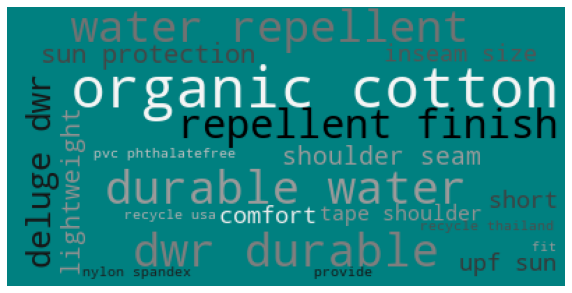

In [448]:
# generate wordcloud to get a feel of the df

# Import matplotlib and wordcloud 
import matplotlib.pyplot as plt
import wordcloud

# Instanciate WordCloud 
wd = wordcloud.WordCloud(colormap = "binary", max_words=20, background_color = "teal")
cloud = wd.generate(" ".join(corpus["clean_document"]))

# Show word cloud with matplotlib 
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cloud)
plt.show()


### The wordcloud is not very telling
- Let's see how we do after the TFIDF Matrix




# Creating a TFIDF Matrix
- Now that we have cleaned up our text it's ready for processing
- Let's use sklearn vectorizer in order to create a TFIDF matrix with our clean_document column
- We will then be able to put this matrix into a new DataFrame in order to run some clustering and SVD on it

In [450]:
# import vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [451]:
# apply vectorizer so the document column
vectorizer = TfidfVectorizer(smooth_idf=True, stop_words='english')
X = vectorizer.fit_transform(corpus['clean_document'])

In [452]:
X

<500x4242 sparse matrix of type '<class 'numpy.float64'>'
	with 29479 stored elements in Compressed Sparse Row format>

In [453]:
# transform this sparse matrix into a numpy array 
X_dense = X.toarray()
print(X_dense.shape)

(500, 4242)


In [457]:
# let's check out the vocabulary of this doc
print(len(vectorizer.vocabulary_))
vectorizer.vocabulary_

4242


{'active': 31,
 'classic': 577,
 'boxer': 374,
 'reason': 2828,
 'cult': 807,
 'favorite': 1235,
 'cool': 719,
 'especially': 1150,
 'sticky': 3466,
 'situation': 3243,
 'quickdrye': 2773,
 'lightweight': 2018,
 'underwear': 3927,
 'minimal': 2233,
 'space': 3374,
 'travel': 3815,
 'pack': 2497,
 'expose': 1184,
 'brushed': 412,
 'waistband': 4052,
 'offer': 2410,
 'nexttoskin': 2353,
 'softness': 3350,
 'fivepanel': 1285,
 'construction': 698,
 'traditional': 3796,
 'fit': 1281,
 'functional': 1436,
 'fly': 1345,
 'recycle': 2837,
 'moisturewicke': 2265,
 'performance': 2578,
 'inseam': 1810,
 'size': 3244,
 'silky': 3210,
 'capilene': 473,
 'ultralight': 3903,
 'breathable': 385,
 'quicktodry': 2779,
 'brush': 411,
 'elastic': 1082,
 'comfort': 644,
 'panel': 2517,
 'allrecycle': 95,
 'gladiodor': 1477,
 'natural': 2320,
 'odor': 2408,
 'control': 710,
 'garment': 1451,
 'mexico': 2196,
 'sport': 3402,
 'briefs': 397,
 'skin': 3254,
 'glory': 1486,
 'require': 2902,
 'movement': 2291

In [458]:
# Let's put the matrix into a DF with the feature name (ie word) as column title and the document number as ID
# this is easily doable because the get_feature_names method of vectorizer returns the feature names 
# with the same index as their values in the X_dense matrix
X_df = pd.DataFrame(X_dense, 
             columns=[x for x in vectorizer.get_feature_names()], 
             index=["doc_{}".format(i) for i in range (1,501)])

In [459]:
X_df.head(10)

ab  abandon  ability  able  aboveknee  abovetheknee  abrasion  \
doc_1   0.0      0.0      0.0   0.0        0.0           0.0       0.0   
doc_2   0.0      0.0      0.0   0.0        0.0           0.0       0.0   
doc_3   0.0      0.0      0.0   0.0        0.0           0.0       0.0   
doc_4   0.0      0.0      0.0   0.0        0.0           0.0       0.0   
doc_5   0.0      0.0      0.0   0.0        0.0           0.0       0.0   
doc_6   0.0      0.0      0.0   0.0        0.0           0.0       0.0   
doc_7   0.0      0.0      0.0   0.0        0.0           0.0       0.0   
doc_8   0.0      0.0      0.0   0.0        0.0           0.0       0.0   
doc_9   0.0      0.0      0.0   0.0        0.0           0.0       0.0   
doc_10  0.0      0.0      0.0   0.0        0.0           0.0       0.0   

        abrasionresistance  abrasionresistant  abrasive  ...  zipoff  \
doc_1                  0.0                0.0       0.0  ...     0.0   
doc_2                  0.0                0.0       0.0  ...     0.0   
doc_3                  0.0                0.0       0.0  ...     0.0   
doc_4                  0.0                0.0       0.0  ...     0.0   
doc_5                  0.0                0.0       0.0  ...     0.0   
doc_6                  0.0                0.0       0.0  ...     0.0   
doc_7                  0.0                0.0       0.0  ...     0.0   
doc_8                  0.0                0.0       0.0  ...     0.0   
doc_9                  0.0                0.0       0.0  ...     0.0   
doc_10                 0.0                0.0       0.0  ...     0.0   

          zipper  zippered  zipperedorganizer   zippers  zippocket  \
doc_1   0.000000  0.000000                0.0  0.000000        0.0   
doc_2   0.000000  0.000000                0.0  0.000000        0.0   
doc_3   0.000000  0.000000                0.0  0.000000        0.0   
doc_4   0.296078  0.000000                0.0  0.000000        0.0   
doc_5   0.109209  0.000000                0.0  0.080239        0.0   
doc_6   0.202774  0.000000                0.0  0.000000        0.0   
doc_7   0.224215  0.047019                0.0  0.000000        0.0   
doc_8   0.000000  0.000000                0.0  0.000000        0.0   
doc_9   0.000000  0.000000                0.0  0.000000        0.0   
doc_10  0.000000  0.000000                0.0  0.000000        0.0   

        zipsecurity  zipthrough  zone  zones  
doc_1           0.0         0.0   0.0    0.0  
doc_2           0.0         0.0   0.0    0.0  
doc_3           0.0         0.0   0.0    0.0  
doc_4           0.0         0.0   0.0    0.0  
doc_5           0.0         0.0   0.0    0.0  
doc_6           0.0         0.0   0.0    0.0  
doc_7           0.0         0.0   0.0    0.0  
doc_8           0.0         0.0   0.0    0.0  
doc_9           0.0         0.0   0.0    0.0  
doc_10          0.0         0.0   0.0    0.0  

[10 rows x 4242 columns]

### Our matrix is ready to be analysed by the ML algorithms! 

# Clustering with DB SCAN
- Now that we have a matrix that is clean and formatted, we can run a DB Scan Algorithm on it 
- The challenge with DB Scan is finding the right hyper parameters, here we have iterated manually to find the right ones but won't show this process

In [460]:
# import dbscan and run model on matrix. parameters were found through trial and error
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

db.fit(X_df)

DBSCAN(algorithm='brute', eps=0.7, metric='cosine', min_samples=3)

In [461]:
# count number of clusters
np.unique(db.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23])

In [462]:
# add the  clusters (including outliers) to matrix --> we can do this because index stays the same
X_df["clusters_DB"] = db.labels_


In [463]:
#check
X_df.head(2)

ab  abandon  ability  able  aboveknee  abovetheknee  abrasion  \
doc_1  0.0      0.0      0.0   0.0        0.0           0.0       0.0   
doc_2  0.0      0.0      0.0   0.0        0.0           0.0       0.0   

       abrasionresistance  abrasionresistant  abrasive  ...  zipper  zippered  \
doc_1                 0.0                0.0       0.0  ...     0.0       0.0   
doc_2                 0.0                0.0       0.0  ...     0.0       0.0   

       zipperedorganizer  zippers  zippocket  zipsecurity  zipthrough  zone  \
doc_1                0.0      0.0        0.0          0.0         0.0   0.0   
doc_2                0.0      0.0        0.0          0.0         0.0   0.0   

       zones  clusters_DB  
doc_1    0.0            0  
doc_2    0.0           -1  

[2 rows x 4243 columns]

In [464]:
# add the  clusters (including outliers) to corpus ---> we can do this because index stays the same
corpus["clusters_DB"] = db.labels_

In [465]:
# check
corpus.head(2)

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   

                                   clean_description  \
0  active classic boxers  theres a reason why our...   
1  active sport boxer briefs  skinning up glory r...   

                                        clean_tokens  \
0  (active, classic, boxers,  , there, s, a, reas...   
1  (active, sport, boxer, briefs,  , skinning, up...   

                             clean_tokens_lemmatized  \
0  [active, classic, boxer,  , s, reason, boxer, ...   
1  [active, sport, boxer, briefs,  , skin, glory,...   

                                      clean_document  clusters_DB  
0  active classic boxer   s reason boxer cult fav...            0  
1  active sport boxer briefs   skin glory require...           -1

In [466]:
# count number of documents per cluster
corpus["clusters_DB"].value_counts()

 1     131
-1      80
 5      55
 0      48
 12     24
 2      21
 4      20
 19     15
 13     14
 22     10
 16      9
 3       9
 6       8
 9       8
 17      7
 11      6
 10      5
 15      5
 21      4
 23      4
 14      4
 20      4
 7       3
 8       3
 18      3
Name: clusters_DB, dtype: int64

# Analyzing our DB clusters
- Let's look at which documents are clustered together
- Let'have a look at most common words per clusters
- Let's have a look at words with highest TF IDF per cluster
- Let's plot out some word clouds

### Let's print 2 random docs for each cluster

In [469]:
# print 3 random document for each cluster
for a in corpus["clusters_DB"].value_counts().index:
    print("-------------------------------------")
    print("cluster {}".format(a))
    for i in range (0, 3):
        print(corpus[corpus["clusters_DB"] == a].sample(1).iloc[0, 1])
        print("")

-------------------------------------
cluster 1
Nine trails vest - Simplicity in action -  this vest protects the core, moves, breathes, and weighs nearly nothing. The lightweight, wind-resistant 15-denier 100% nylon is treated with a Deluge DWR (durable water repellent) finish to shed light rain, and the exceptionally breathable stretch-woven back panel (91% all-recycled polyester/9% spandex) vents excess heat. The high-rise tricot-lined neck provides a tight seal; the armholes and hem now have elastic binding. Reflective heat-transfer logos (front and back) and a reflective center-back zippered pocket keep you visible.<br><br><b>Details:</b><ul> <li>"Light, slightly transparent, tough, triple-ripstop nylon soft shell on torso and shoulders; breathable recycled polyester stretch-woven fabric on back; vest is treated with a Deluge DWR (durable water repellent) finish for weather protection"</li> <li>Elastic binding at armholes and hem for a good fit</li> <li>Center-back reflective zipp

### Now let's have a look at the most common words per cluster

In [471]:
# we can use counter to do this
for a in corpus["clusters_DB"].value_counts().index:
    print("-------------------------------------")
    print("cluster {}".format(a))
    word_count = Counter(' '.join((corpus[corpus["clusters_DB"] == a]['clean_document'])).split(' ')).items()
                         
    word_count = pd.DataFrame({'word': [item[0] for item in list(word_count)], 
             'count' : [item[1] for item in list (word_count)]})
                         
    word_count = word_count.sort_values('count', ascending = False)
    word_count = word_count[word_count["word"]!= ""]
    print(word_count.head(5))


-------------------------------------
cluster 1
       word  count
41   pocket    383
44  recycle    257
48   finish    183
29   zipper    183
45      dwr    181
-------------------------------------
cluster -1
        word  count
15   recycle    144
100   pocket    125
180   cotton    106
185  organic    104
20   spandex     54
-------------------------------------
cluster 5
        word  count
16   organic    115
17    cotton    112
31   recycle    104
2     tshirt     97
18  ringspun     96
-------------------------------------
cluster 0
       word  count
31  recycle    156
50  control     78
80      sun     73
49     odor     71
48  natural     71
-------------------------------------
cluster 12
             word  count
28         merino    120
29           wool     89
135           dry     50
148          odor     44
61   construction     43
-------------------------------------
cluster 2
        word  count
24    pocket    118
30     strap     69
40      deni     65
15  shoulder

### We can also check those with the higest TF/IDF value per cluster

In [472]:

cols = [c for c in X_df.columns if c!='clusters_DB']

for c in corpus['clusters_DB'].value_counts().index :
    print("Cluster ", c)
    print(X_df.loc[X_df['clusters_DB']==c, cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

Cluster  1
pocket    0.105756
dwr       0.062357
inseam    0.061242
finish    0.059494
zipper    0.059246
dtype: float64
-----------
Cluster  -1
cotton     0.069811
organic    0.068332
pocket     0.055724
recycle    0.054361
shirt      0.038423
dtype: float64
-----------
Cluster  5
ringspun         0.175182
phthalatefree    0.169607
pvc              0.168719
tape             0.166340
ink              0.162877
dtype: float64
-----------
Cluster  0
gladiodor    0.117660
control      0.114173
natural      0.109853
capilene     0.107971
odor         0.106554
dtype: float64
-----------
Cluster  12
merino          0.357639
wool            0.266496
odor            0.106086
construction    0.105867
chlorinefree    0.103472
dtype: float64
-----------
Cluster  2
pocket          0.150451
strap           0.137649
deni            0.137069
compartment     0.123615
polyurethane    0.120097
dtype: float64
-----------
Cluster  4
fleece        0.296035
doubleface    0.098612
pocket        0.092466
trim 

### Finally let's make a wordcloud for each cluster

cluster 1


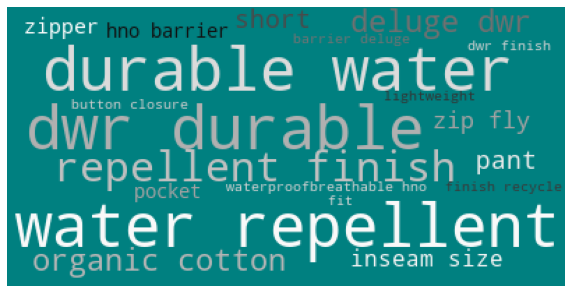

cluster -1


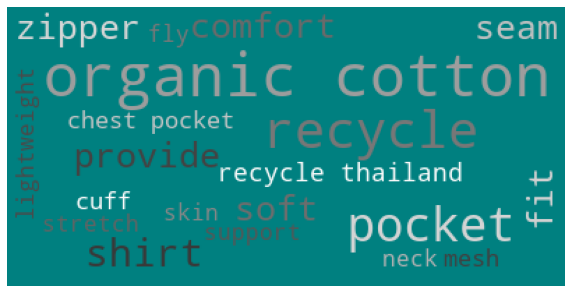

cluster 5


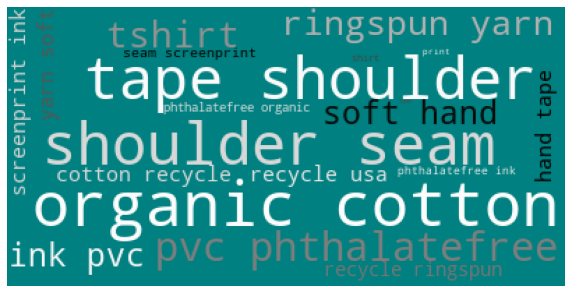

cluster 0


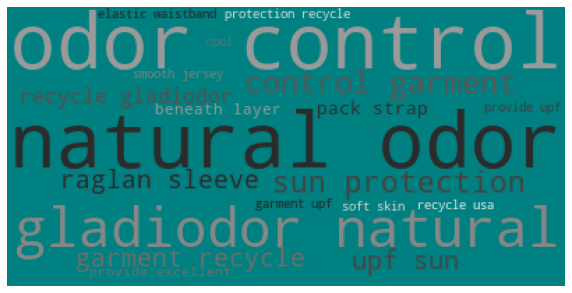

cluster 12


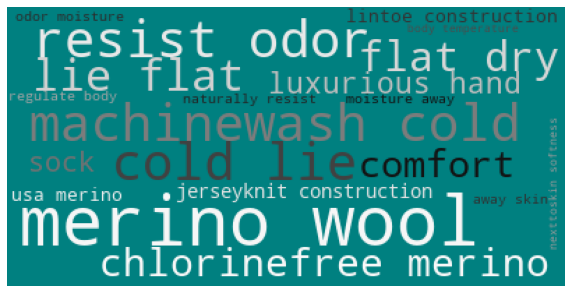

cluster 2


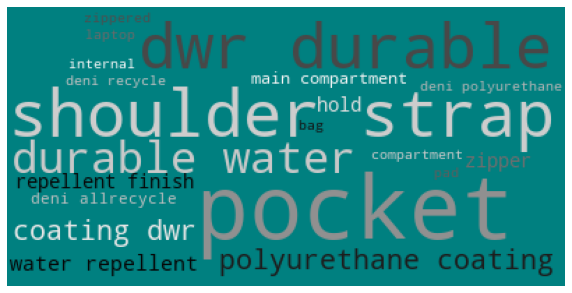

cluster 4


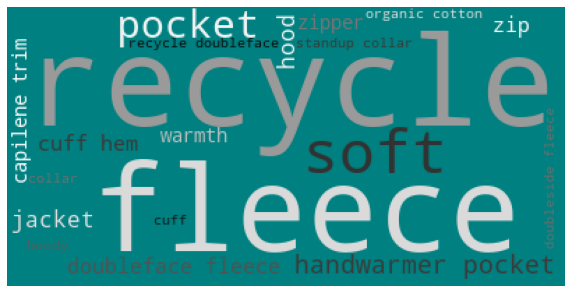

cluster 19


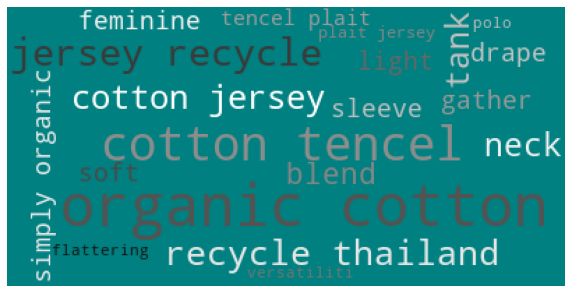

cluster 13


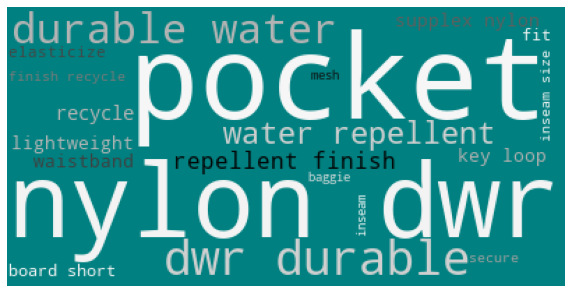

cluster 22


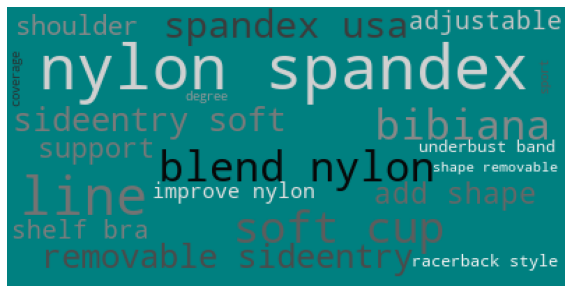

cluster 16


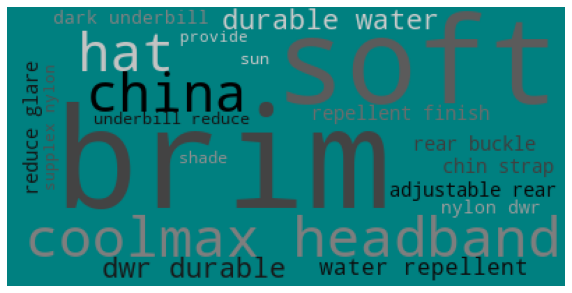

cluster 3


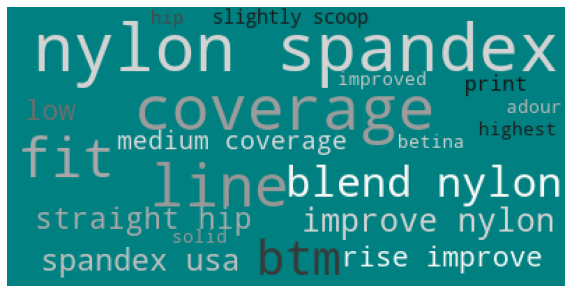

cluster 6


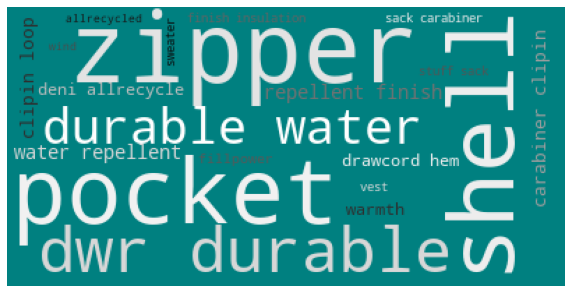

cluster 9


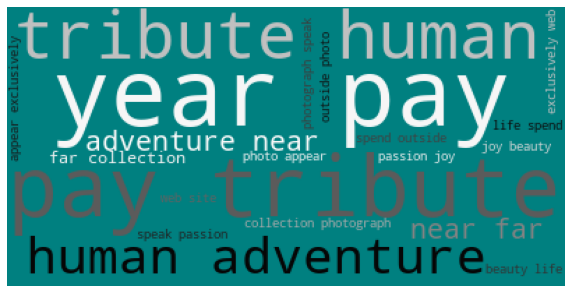

cluster 17


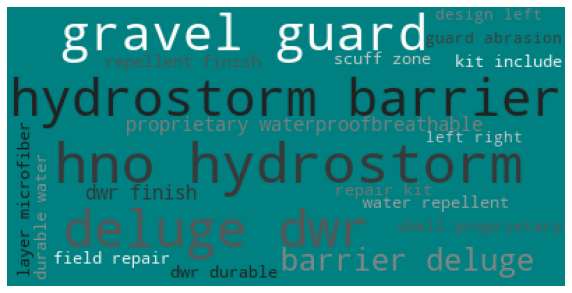

cluster 11


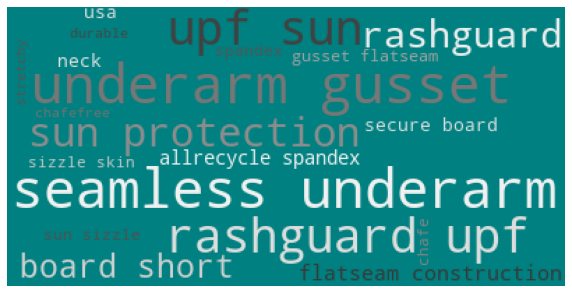

cluster 10


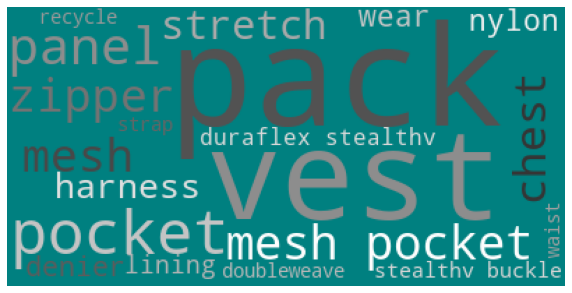

cluster 15


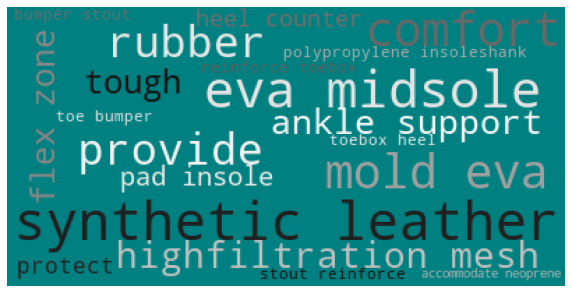

cluster 21


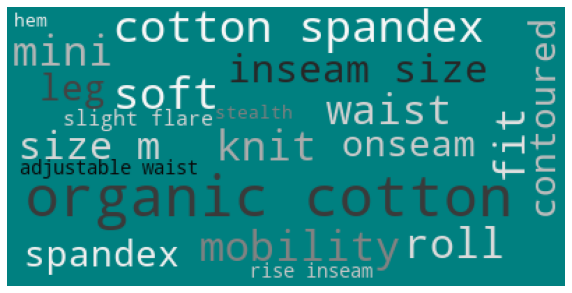

cluster 23


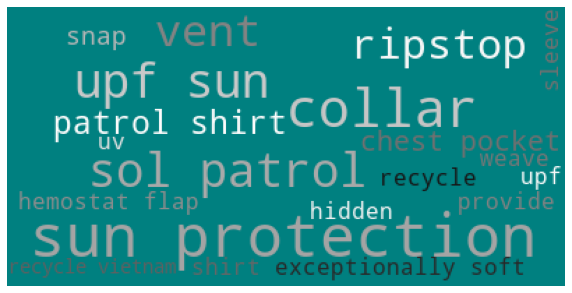

cluster 14


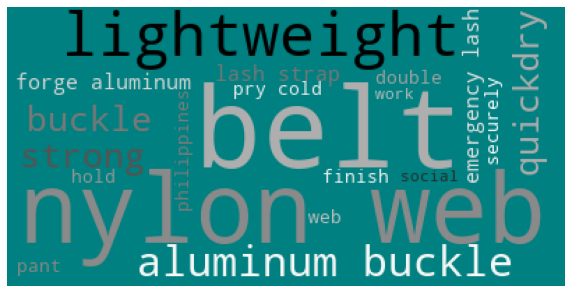

cluster 20


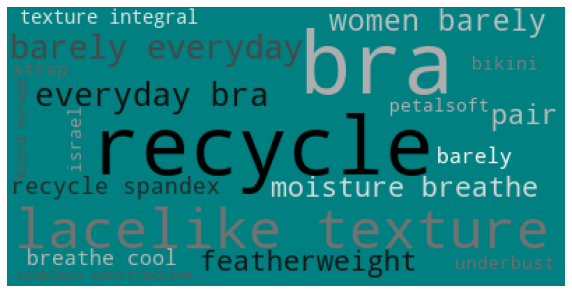

cluster 7


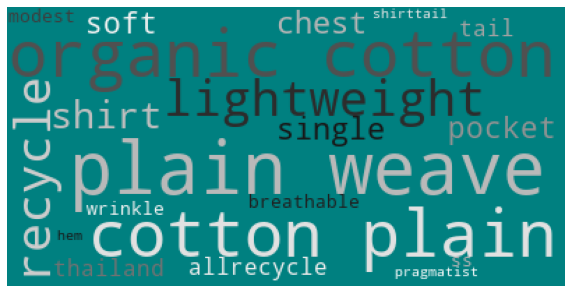

cluster 8


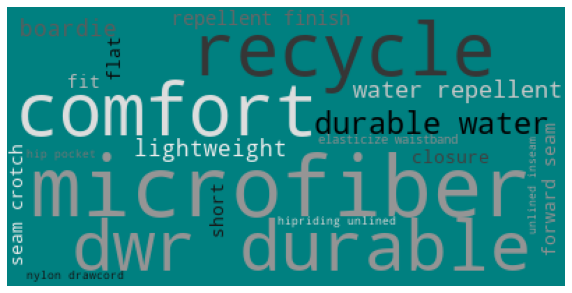

cluster 18


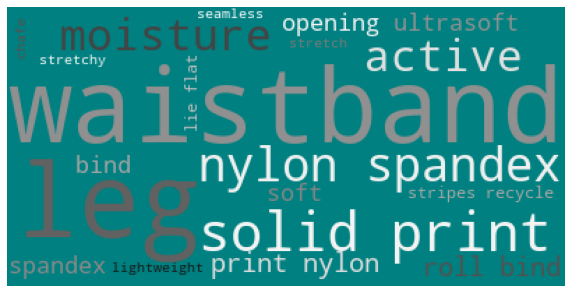

In [474]:
# Instanciate WordCloud 


for i in corpus["clusters_DB"].value_counts().index:
    print("cluster {}".format(i))
    wd = wordcloud.WordCloud(colormap = "Greys", max_words=20, background_color = "teal")
    x = corpus[corpus["clusters_DB"] == i]
    cloud = wd.generate(" ".join(x["clean_document"]))
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()



## Not so bad
- Some clusters make sense and we can see that they regroup words with similar meaning
- But others seem quite random

# Clustering with KMeans
- Let's try to cluster the docs with KMeans
- This is unlikely to yield good results 


In [475]:
# import packages
from sklearn.cluster import KMeans
import seaborn as sns

In [181]:
# Let's create a loop that will collect the Within-sum-of-square (wcss) for each value K 
# Let's use .inertia_ parameter to get the within sum of square value for each value K 
wcss =  []
K = range(1, 21)
for i in K: 
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(X_df_km)
    wcss.append(kmeans.inertia_)
    print("WCSS for K={} --> {}".format(i, wcss[-1]))


WCSS for K=1 --> 469.5770755589126
WCSS for K=2 --> 454.7901129467784
WCSS for K=3 --> 442.5723995019922
WCSS for K=4 --> 432.9745125727818
WCSS for K=5 --> 425.4457446531751
WCSS for K=6 --> 417.6749328927325
WCSS for K=7 --> 412.58613841530786
WCSS for K=8 --> 409.69424983040176
WCSS for K=9 --> 403.3380420308985
WCSS for K=10 --> 397.00377767939324
WCSS for K=11 --> 390.3259397596464
WCSS for K=12 --> 385.38068697265084
WCSS for K=13 --> 381.04420765259533
WCSS for K=14 --> 377.7772410616574
WCSS for K=15 --> 375.8685920979255
WCSS for K=16 --> 372.848624117575
WCSS for K=17 --> 369.445946470494
WCSS for K=18 --> 365.25716727293093
WCSS for K=19 --> 364.41652891957546
WCSS for K=20 --> 360.44899842720906


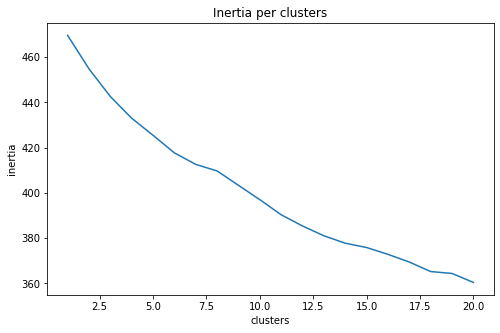

In [182]:
palette = ['navy', 'teal', 'lightskyblue', "lightblue"]

# Create DataFrame
wcss_frame = pd.DataFrame(wcss)

# create figure
fig, ax = plt.subplots(figsize=(8, 5))
    
ax = sns.lineplot(
    data = wcss_frame,
    x=K,
    y=wcss_frame.iloc[:,-1],
)

ax.set(xlabel='clusters', ylabel='inertia', title= "Inertia per clusters")

plt.show()



We can see that even with K=20, the score is still decreasing quite strongly 

In [183]:
# Import silhouette score
from sklearn.metrics import silhouette_score

# Computer mean silhouette score
sil = []

# Select K as a range starting at 2 as silhouette score cannot accept less than 2 labels 
K = range(2, 21)

## Run new K-Means with silhouette score
for i in K: 
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(X_df_km)
    sil.append(silhouette_score(X_df_km, kmeans.predict(X_df_km)))
    print("Silhouette score for K={} is {}".format(i, sil[-1]))

Silhouette score for K=2 is 0.03042881907647891
Silhouette score for K=3 is 0.03664265131086814
Silhouette score for K=4 is 0.04193661206911753
Silhouette score for K=5 is 0.04566323337494412
Silhouette score for K=6 is 0.05240485169625684
Silhouette score for K=7 is 0.05542270146346616
Silhouette score for K=8 is 0.05488685949286003
Silhouette score for K=9 is 0.05910409332705821
Silhouette score for K=10 is 0.06485634608184426
Silhouette score for K=11 is 0.07169733102396451
Silhouette score for K=12 is 0.07498973016427296
Silhouette score for K=13 is 0.07767924955675312
Silhouette score for K=14 is 0.0655951883651717
Silhouette score for K=15 is 0.06541245257822238
Silhouette score for K=16 is 0.08030071393713048
Silhouette score for K=17 is 0.07115018041320573
Silhouette score for K=18 is 0.08728160801967468
Silhouette score for K=19 is 0.08783780304150945
Silhouette score for K=20 is 0.07708933744773151


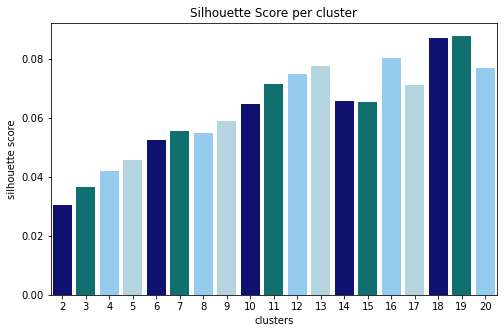

In [184]:

# Create a data frame 
cluster_scores=pd.DataFrame(sil)

#create figure
palette = ['navy', 'teal', 'lightskyblue', "lightblue"]
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.barplot(
    data = cluster_scores,
    x=list(K),
    y=cluster_scores.iloc[:, -1],
    palette = palette
)
ax.set(xlabel='clusters', ylabel='silhouette score', title= "Silhouette Score per cluster")

plt.show()



From both the elbow method and silhouette score, we can select 19 as an acceptable number of clusters

# import seaborn as sns

In [476]:
# instantiate model
cluster = KMeans(n_clusters=19, random_state=0, init="k-means++")

In [477]:
# fit to our data --> we added original clusters to df so we need to make sure not to take this column
cluster.fit(X_df.iloc[:, :-1])

KMeans(n_clusters=19, random_state=0)

In [478]:
# add kmeans clusters to our corpus df
corpus["clusters_KMeans"] = cluster.labels_

In [479]:
# add kmeans clusters to our matrix
X_df["clusters_KMeans"] = cluster.labels_

In [480]:
#check
corpus.head(2)

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   

                                   clean_description  \
0  active classic boxers  theres a reason why our...   
1  active sport boxer briefs  skinning up glory r...   

                                        clean_tokens  \
0  (active, classic, boxers,  , there, s, a, reas...   
1  (active, sport, boxer, briefs,  , skinning, up...   

                             clean_tokens_lemmatized  \
0  [active, classic, boxer,  , s, reason, boxer, ...   
1  [active, sport, boxer, briefs,  , skin, glory,...   

                                      clean_document  clusters_DB  \
0  active classic boxer   s reason boxer cult fav...            0   
1  active sport boxer briefs   skin glory require...           -1   

   clusters_KMeans  
0                8  
1                1

In [481]:
# count values per cluster
corpus["clusters_KMeans"].value_counts()

1     64
5     61
0     59
8     44
4     31
15    29
7     26
6     25
2     23
3     23
9     20
12    17
11    16
17    14
13    12
10    11
16    10
18     8
14     7
Name: clusters_KMeans, dtype: int64

### Now let's have a look at the most common words per cluster

In [482]:
# count most common words per cluster
for a in corpus["clusters_KMeans"].value_counts().index:
    print("-------------------------------------")
    print("clusters_KMeans {}".format(a))
    word_count = Counter(' '.join((corpus[corpus["clusters_KMeans"] == a]['clean_document'])).split(' ')).items()
                         
    word_count = pd.DataFrame({'word': [item[0] for item in list(word_count)], 
             'count' : [item[1] for item in list (word_count)]})
                         
    word_count = word_count.sort_values('count', ascending = False)
    word_count = word_count[word_count["word"]!= ""]
    print(word_count.head(5))


-------------------------------------
clusters_KMeans 1
        word  count
92    pocket    200
15   recycle    143
31    inseam    117
125    nylon    113
66   durable     86
-------------------------------------
clusters_KMeans 5
       word  count
16  organic    122
17   cotton    119
31  recycle    116
2    tshirt    106
22     seam    102
-------------------------------------
clusters_KMeans 0
        word  count
10   organic    164
11    cotton    153
32   recycle    107
111     soft     47
143   jersey     44
-------------------------------------
clusters_KMeans 8
         word  count
31    recycle    163
50    control     79
49       odor     72
48    natural     72
47  gladiodor     72
-------------------------------------
clusters_KMeans 4
       word  count
40  organic    104
41   cotton     99
11   pocket     97
55  recycle     66
51   inseam     57
-------------------------------------
clusters_KMeans 15
                     word  count
44                 pocket    101
36 

### Words with highest TFIDF per cluster

In [483]:

# cols = [c for c in X_df.columns if c!='clusters']
cols = X_df.iloc[:, :-2].columns

for c in corpus['clusters_KMeans'].value_counts().index :
    print("clusters_KMeans ", c)
    print(X_df.loc[X_df['clusters_KMeans']==c, cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

clusters_KMeans  1
pocket    0.118655
inseam    0.108049
nylon     0.091100
fly       0.068722
pant      0.067708
dtype: float64
-----------
clusters_KMeans  5
ringspun         0.165632
phthalatefree    0.160646
pvc              0.159805
tape             0.157620
tshirt           0.157010
dtype: float64
-----------
clusters_KMeans  0
organic    0.152036
cotton     0.141232
tencel     0.064236
jersey     0.061528
recycle    0.060570
dtype: float64
-----------
clusters_KMeans  8
gladiodor    0.129774
control      0.125814
natural      0.121164
capilene     0.120468
odor         0.117525
dtype: float64
-----------
clusters_KMeans  4
organic    0.185663
cotton     0.175553
canvas     0.157596
pocket     0.134848
inseam     0.125725
dtype: float64
-----------
clusters_KMeans  15
waterproofbreathable    0.162250
barrier                 0.152380
hno                     0.128885
layer                   0.125638
zipper                  0.116194
dtype: float64
-----------
clusters_KMeans  7
refl

clusters_KMeans 1


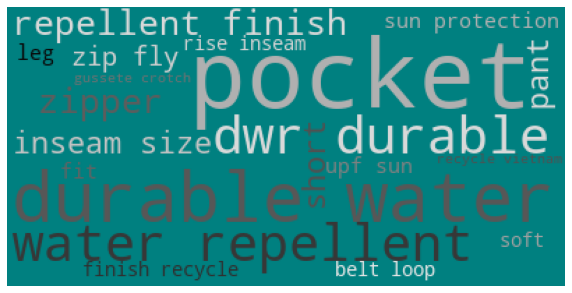

clusters_KMeans 5


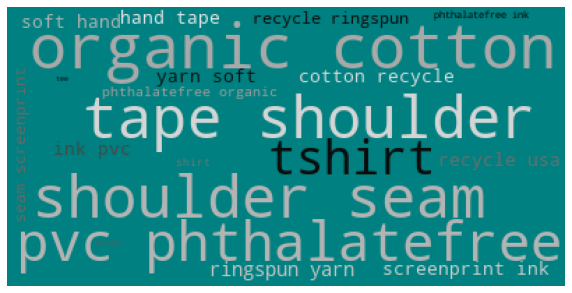

clusters_KMeans 0


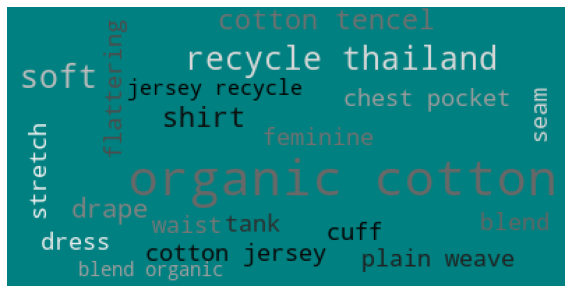

clusters_KMeans 8


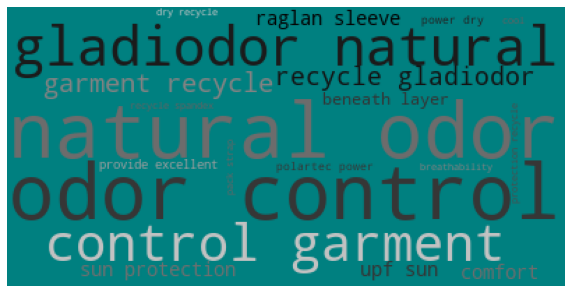

clusters_KMeans 4


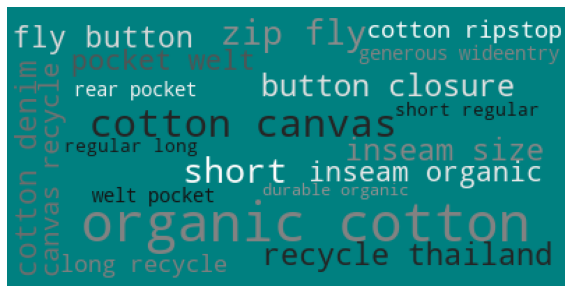

clusters_KMeans 15


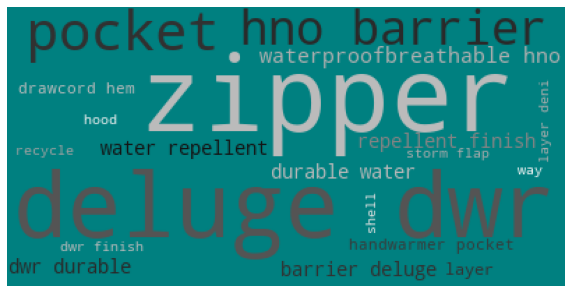

clusters_KMeans 7


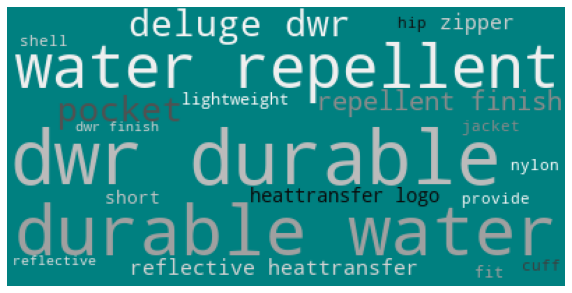

clusters_KMeans 6


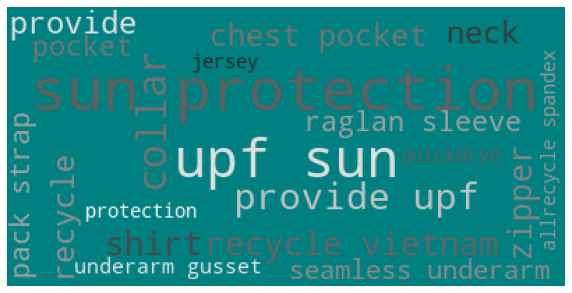

clusters_KMeans 2


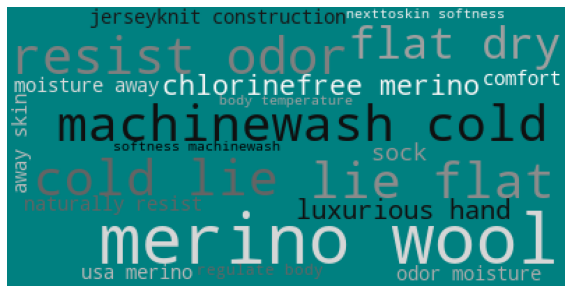

clusters_KMeans 3


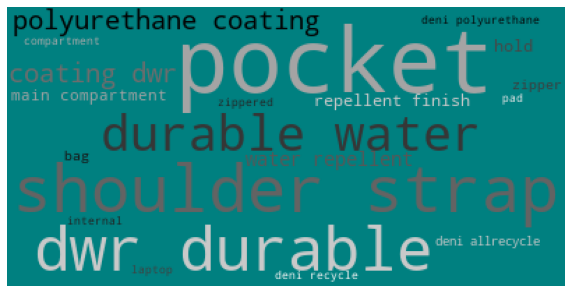

clusters_KMeans 9


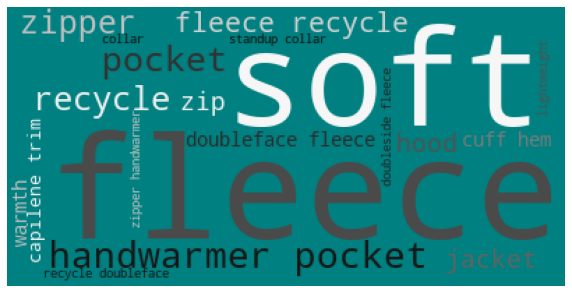

clusters_KMeans 12


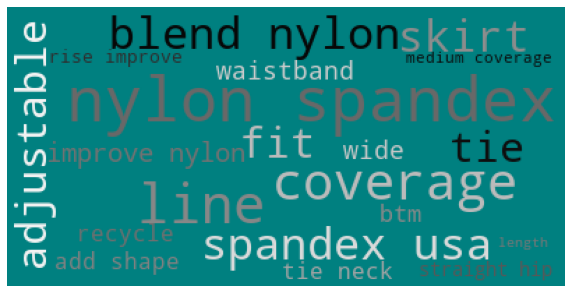

clusters_KMeans 11


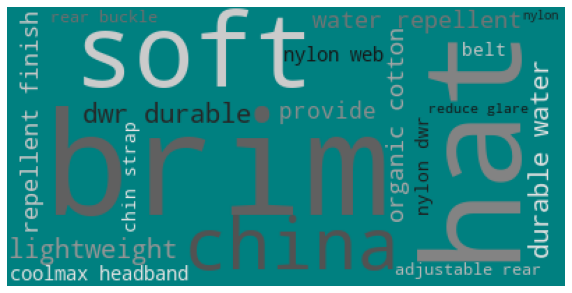

clusters_KMeans 17


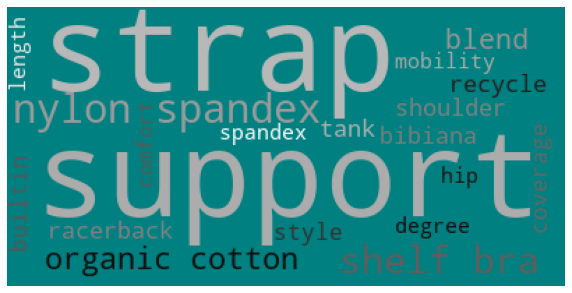

clusters_KMeans 13


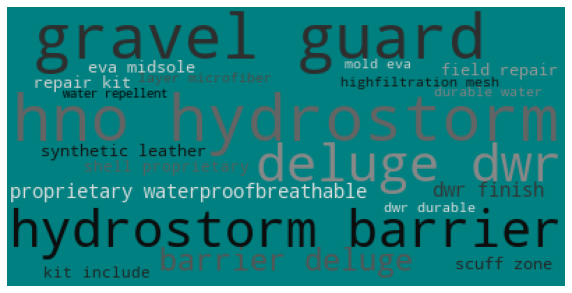

clusters_KMeans 10


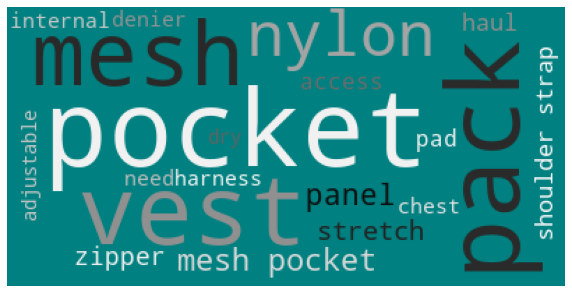

clusters_KMeans 16


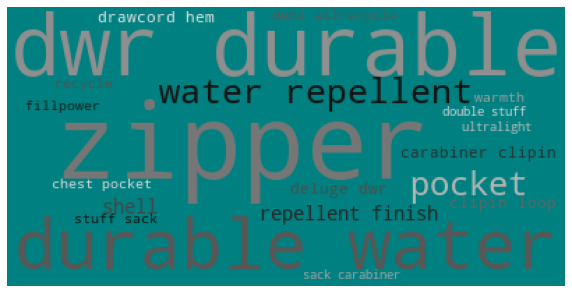

clusters_KMeans 18


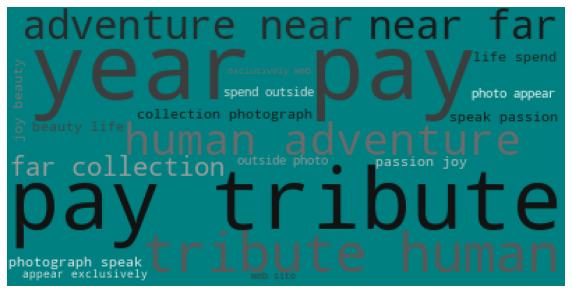

clusters_KMeans 14


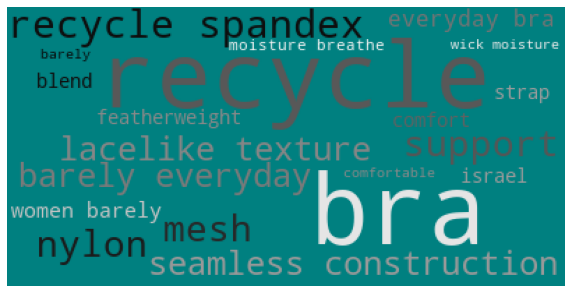

In [484]:
# Instanciate WordCloud 


for i in corpus["clusters_KMeans"].value_counts().index:
    print("clusters_KMeans {}".format(i))
    wd = wordcloud.WordCloud(colormap = "gray", max_words=20, background_color = "teal")
    x = corpus[corpus["clusters_KMeans"] == i]
    cloud = wd.generate(" ".join(x["clean_document"]))
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()


# Clustering Conclusion 
- Clustering algorithms yield somewhat approximate results. DB Scan does manage to create some clusters, but it is not easy to extract any specific trend from the wordclouds
- Kmeans does not yield anything significant
- Let's give a try at dimensionality reduction and using a truncated SVD to see if we can get better results

# TruncatedSVD 
- Let's see if we can use a truncated SVD algorithm to get some common topics out of those docs
- This will most likely return clusters with decreasing amount of documents in them

In [485]:
# import from sklearn
from sklearn.decomposition import TruncatedSVD

In [486]:
# inspect default parameters
import inspect
inspect.signature(TruncatedSVD)

<Signature (n_components=2, *, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)>

In [487]:
# set it to 12 different topics 
svd = TruncatedSVD(n_components=12)

# fit to our matrix --> last two columns are those with the previous cluster_values
lsa = svd.fit_transform(X_df.iloc[:, :-2])

In [488]:
# check shape
lsa.shape

(500, 12)

Returns the right values --> 500 docs and 15 topics

In [489]:
# store values into a dataframe
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_{}".format(i) \
                                                for i in range(1,(lsa.shape[1]+1))]\
                               )
topic_encoded_df.head()

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0  0.191876 -0.034662  0.149982  0.114656 -0.108615 -0.004609 -0.095508   
1  0.194100 -0.049260  0.080739  0.113010 -0.023910  0.087861  0.022063   
2  0.177276 -0.053981  0.085398  0.054192 -0.022278  0.082854  0.135638   
3  0.337065 -0.225239 -0.085396 -0.127895  0.005256  0.007366 -0.091777   
4  0.348943 -0.232370 -0.011925 -0.240796 -0.030402 -0.032032  0.030936   

    topic_8   topic_9  topic_10  topic_11  topic_12  
0 -0.001783 -0.144349 -0.019020  0.006505 -0.038295  
1 -0.029544 -0.117918 -0.028883 -0.015926  0.030662  
2  0.002393 -0.088972 -0.031996  0.034634  0.095014  
3 -0.065079 -0.090189  0.014242 -0.136767 -0.142531  
4 -0.000401 -0.015021  0.019102 -0.178890 -0.216909

In [491]:
# add document corresponding to each topic. This works because indexes are the same
topic_encoded_df["document"] = corpus["clean_document"]
topic_encoded_df.head(3)

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0  0.191876 -0.034662  0.149982  0.114656 -0.108615 -0.004609 -0.095508   
1  0.194100 -0.049260  0.080739  0.113010 -0.023910  0.087861  0.022063   
2  0.177276 -0.053981  0.085398  0.054192 -0.022278  0.082854  0.135638   

    topic_8   topic_9  topic_10  topic_11  topic_12  \
0 -0.001783 -0.144349 -0.019020  0.006505 -0.038295   
1 -0.029544 -0.117918 -0.028883 -0.015926  0.030662   
2  0.002393 -0.088972 -0.031996  0.034634  0.095014   

                                            document  
0  active classic boxer   s reason boxer cult fav...  
1  active sport boxer briefs   skin glory require...  
2  active sport briefs   superbreathable nofly br...

In [492]:
#add main topic per document --> based on highest absolute value per row
topic_encoded_df["main_topic"] = topic_encoded_df.iloc[:, :-1].\
                                                            apply(lambda x: topic_encoded_df.iloc[:, :-1]\
                                                            .columns[abs(x)\
                                                            .argmax()],  axis=1)

In [493]:
# do same with value so we can keep track of it
topic_encoded_df["main_topic_value"] =  topic_encoded_df.iloc[:, :-2]\
                                                                   .apply(lambda x: max(x),  axis=1)

In [494]:
# check
topic_encoded_df.head()

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0  0.191876 -0.034662  0.149982  0.114656 -0.108615 -0.004609 -0.095508   
1  0.194100 -0.049260  0.080739  0.113010 -0.023910  0.087861  0.022063   
2  0.177276 -0.053981  0.085398  0.054192 -0.022278  0.082854  0.135638   
3  0.337065 -0.225239 -0.085396 -0.127895  0.005256  0.007366 -0.091777   
4  0.348943 -0.232370 -0.011925 -0.240796 -0.030402 -0.032032  0.030936   

    topic_8   topic_9  topic_10  topic_11  topic_12  \
0 -0.001783 -0.144349 -0.019020  0.006505 -0.038295   
1 -0.029544 -0.117918 -0.028883 -0.015926  0.030662   
2  0.002393 -0.088972 -0.031996  0.034634  0.095014   
3 -0.065079 -0.090189  0.014242 -0.136767 -0.142531   
4 -0.000401 -0.015021  0.019102 -0.178890 -0.216909   

                                            document main_topic  \
0  active classic boxer   s reason boxer cult fav...    topic_1   
1  active sport boxer briefs   skin glory require...    topic_1   
2  active sport briefs   superbreathable nofly br...    topic_1   
3  alpine guide pant   skin climb ice switch rock...    topic_1   
4  alpine wind jkt   high ridge steep ice alpine ...    topic_1   

   main_topic_value  
0          0.191876  
1          0.194100  
2          0.177276  
3          0.337065  
4          0.348943

In [495]:
# let's add the main topic for each in the corpus document as well 
corpus["main_topic"] = topic_encoded_df["main_topic"]

In [496]:
# check
corpus.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   clean_description  \
0  active classic boxers  theres a reason why our...   
1  active sport boxer briefs  skinning up glory r...   
2  active sport briefs  these superbreathable nof...   
3  alpine guide pants  skin in climb ice switch t...   
4  alpine wind jkt  on high ridges steep ice and ...   

                                        clean_tokens  \
0  (active, classic, boxers,  , there, s, a, reas...   
1  (active, sport, boxer, briefs,  , skinning, up...   
2  (active, sport, briefs,  , these, superbreatha...   
3  (alpine, guide, pants,  , skin, in, climb, ice...   
4  (alpine, wind, jkt,  , on, high, ridges, steep...   

                             clean_tokens_lemmatized  \
0  [active, classic, boxer,  , s, reason, boxer, ...   
1  [active, sport, boxer, briefs,  , skin, glory,...   
2  [active, sport, briefs,  , superbreathable, no...   
3  [alpine, guide, pant,  , skin, climb, ice, swi...   
4  [alpine, wind, jkt,  , high, ridge, steep, ice...   

                                      clean_document  clusters_DB  \
0  active classic boxer   s reason boxer cult fav...            0   
1  active sport boxer briefs   skin glory require...           -1   
2  active sport briefs   superbreathable nofly br...           -1   
3  alpine guide pant   skin climb ice switch rock...            1   
4  alpine wind jkt   high ridge steep ice alpine ...            1   

   clusters_KMeans main_topic  
0                8    topic_1  
1                1    topic_1  
2               14    topic_1  
3                1    topic_1  
4                7    topic_1

In [498]:
# check number of docs per topic
corpus["main_topic"].value_counts()

topic_1     222
topic_2      61
topic_7      51
topic_3      35
topic_8      29
topic_4      24
topic_12     21
topic_9      19
topic_5      19
topic_10      8
topic_11      8
topic_6       3
Name: main_topic, dtype: int64

In [499]:
# print 2 random document for each topic
for a in corpus["main_topic"].value_counts().index:
    print("-------------------------------------")
    print(str(a))
    for i in range (0, 2):
        print(corpus[corpus["main_topic"] == a].sample(1).iloc[0, 1])
        print("")

-------------------------------------
topic_1
Drift shirt - All epic tales of the West begin with a drifter - many were women in search of big skies and a freer life. The Drift Shirt's feminine, high-plains styling includes a delicate collar and a front placket and patch pockets with snaps. The shirt's all-recycled polyester/organic cotton (65%/35%) open-weave fabric is durable and stays cool under pressure. Contouring front and back princess seams; slits at cuffs and hem for venting. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Feminine, open-weave fabric construction"</li> <li>Durable organic cotton/all-recycled polyester blend</li> <li>"Delicate collar, front placket with snaps"</li> <li>Princess seaming front and back for contoured fit</li> <li>Front patch pockets with snap closures</li> <li>Slits at cuffs and hem for venting</li></ul><br><br><b>Fabric: </b>2.8-oz 65% all-recycled polyester/35% organic cotton. Recyclable through the Commo

##  Now, let's yse the attribute components_ of our SVD model to print the 5 most important words in each topic

In [500]:
# crete a matrix mapping out each components with each topic
matrix = pd.DataFrame(svd.components_,
                      columns = [c for c in X_df.iloc[:, :-2].columns],\
                      index =["topic_{}".format(i)for i in range(1,(lsa.shape[1]+1))] 
                     )

print(matrix.shape)
matrix.head(2)


(12, 4242)


ab   abandon   ability      able  aboveknee  abovetheknee  \
topic_1  0.000356  0.001196  0.002697  0.000495   0.000613      0.000557   
topic_2 -0.000186 -0.000476 -0.000966 -0.000379  -0.000534      0.000088   

         abrasion  abrasionresistance  abrasionresistant  abrasive  ...  \
topic_1  0.020496            0.001303           0.005838  0.000949  ...   
topic_2 -0.018878           -0.001061          -0.006148 -0.000772  ...   

           zipoff    zipper  zippered  zipperedorganizer   zippers  zippocket  \
topic_1  0.009005  0.132666  0.056479           0.000731  0.007934   0.000965   
topic_2 -0.007824 -0.124754 -0.050472          -0.000724 -0.008733  -0.000748   

         zipsecurity  zipthrough      zone     zones  
topic_1     0.001652    0.006215  0.006687  0.003109  
topic_2    -0.001316   -0.005274 -0.006537 -0.003786  

[2 rows x 4242 columns]

In [501]:
# print out top 5 words for each topic 
for i in matrix.index: 
    print("--------------------")
    print(str(i))
    print(matrix.loc[i,:].sort_values(ascending = False)[:5].index.tolist())


--------------------
topic_1
['pocket', 'recycle', 'organic', 'cotton', 'zipper']
--------------------
topic_2
['organic', 'cotton', 'ringspun', 'phthalatefree', 'pvc']
--------------------
topic_3
['merino', 'odor', 'wool', 'control', 'gladiodor']
--------------------
topic_4
['organic', 'inseam', 'cotton', 'short', 'canvas']
--------------------
topic_5
['merino', 'wool', 'machinewash', 'lie', 'naturally']
--------------------
topic_6
['nylon', 'sun', 'upf', 'protection', 'spandex']
--------------------
topic_7
['spandex', 'coverage', 'blend', 'tencel', 'jersey']
--------------------
topic_8
['strap', 'pocket', 'polyurethane', 'deni', 'compartment']
--------------------
topic_9
['sun', 'protection', 'upf', 'collar', 'allrecycle']
--------------------
topic_10
['photo', 'poster', 'outside', 'print', 'wall']
--------------------
topic_11
['barrier', 'hno', 'waterproofbreathable', 'hydrostorm', 'proprietary']
--------------------
topic_12
['fleece', 'pocket', 'doubleface', 'collar', 'tr

main_topic topic_1


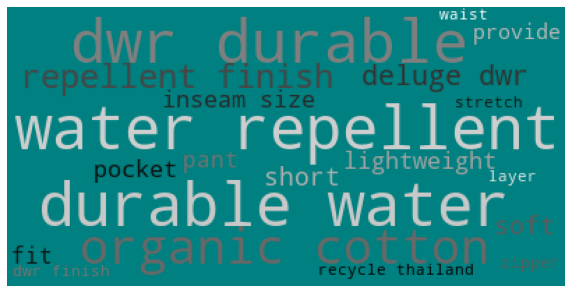

main_topic topic_2


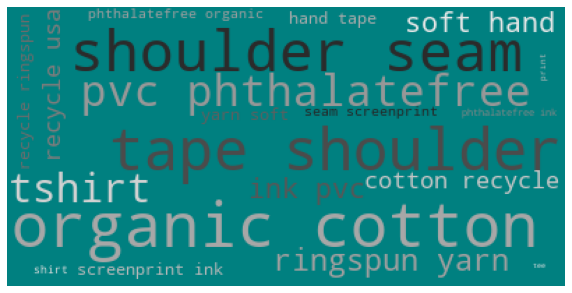

main_topic topic_7


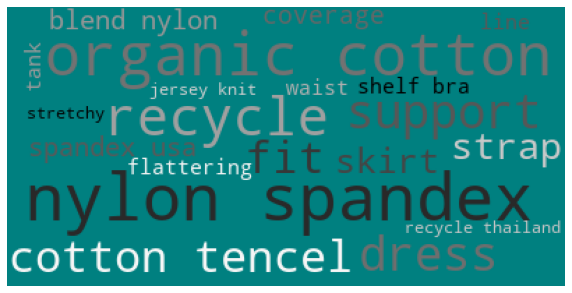

main_topic topic_3


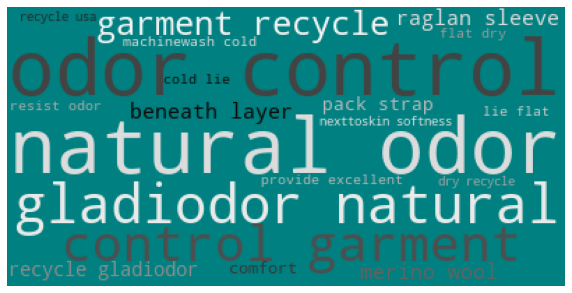

main_topic topic_8


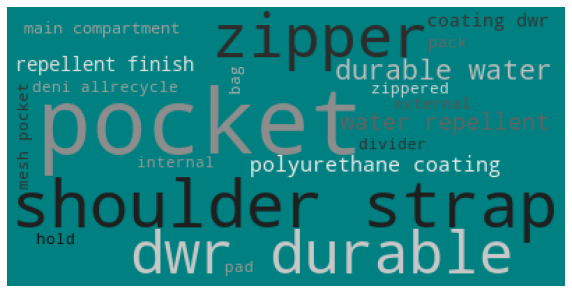

main_topic topic_4


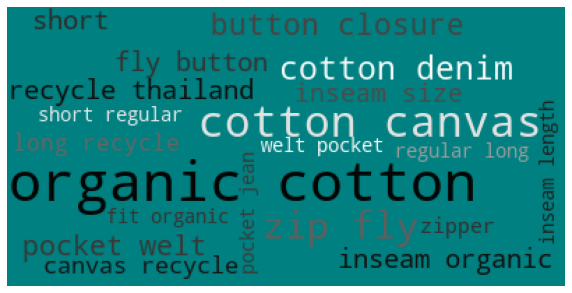

main_topic topic_12


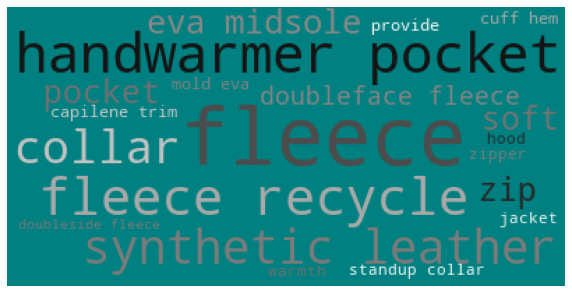

main_topic topic_9


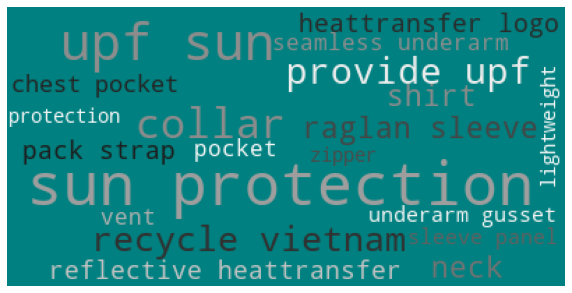

main_topic topic_5


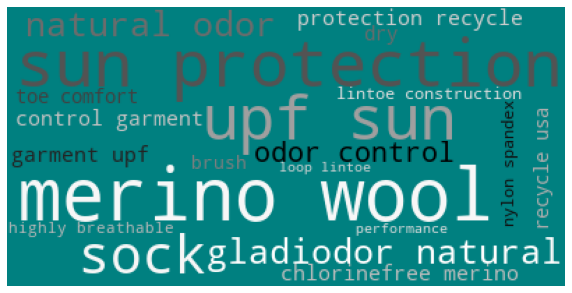

main_topic topic_10


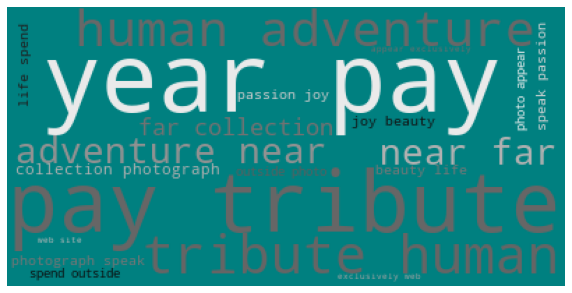

main_topic topic_11


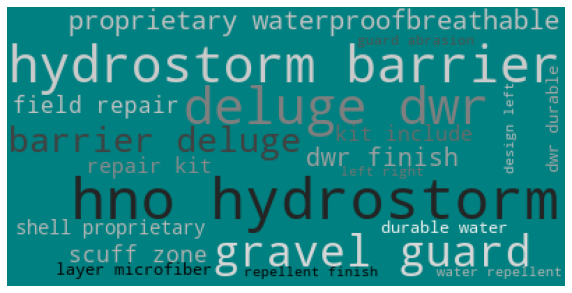

main_topic topic_6


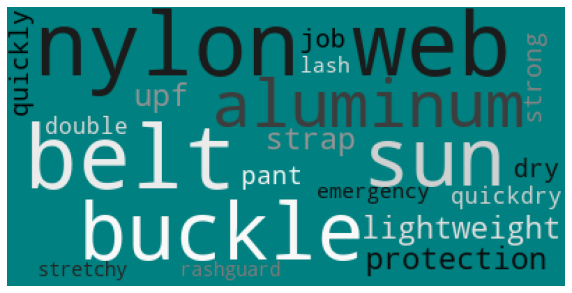

In [502]:
# Instanciate WordCloud for each topic

for i in corpus["main_topic"].value_counts().index:
    print("main_topic {}".format(i))
    wd = wordcloud.WordCloud(colormap = "gray", max_words=20, background_color = "teal")
    x = corpus[corpus["main_topic"] == i]
    cloud = wd.generate(" ".join(x["clean_document"]))
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()


# Conclusion: 
- The SVD seems to perform better than the clusters, as it seems to return more specific topics
- However, there is still no clear cut between topics
- All in all, this was a useful exercise to ptractice basic NLP  